In [1]:
import numpy as np
from scipy.special import  softmax
import matplotlib.pyplot as plt
import os
from matplotlib.collections import LineCollection
from matplotlib.patches import Rectangle
import re
import glob
import modelBasedTrain as mb

In [2]:
SC = 92 * 131 # Number of States
M = 1
cSource = 45.5 # Source coordinates
rSource = 91
cols = 92
rows = 131
find_range = 1.1 # Source radius
gamma = 0.99975
reward = -(1 -gamma)
ActionDict = np.asarray([
            [-1,  0], # North
            [ 0,  1], # East
            [ 1,  0], # South
            [ 0, -1]  # West
        ])
dataC = np.load("celaniData/fine5.npy")
rho = np.zeros(SC * M)
rho[:cols] = (1-dataC[0,:cols])/np.sum((1-dataC[0,:cols]))
R = np.ones(SC*M) * -(1 - gamma)
for s in range(SC):
    r, c = s // 92, s % 92 
    if (r - rSource) ** 2 + (c -cSource) **2 < find_range**2:
        R[s::SC] = 0

In [3]:
def isEnd(state):
    s = np.unravel_index(state, (131, 92))
    return (s[0] - rSource) ** 2 + (s[1] -cSource) **2 < find_range**2

def choose_action(pi, o):
    return np.random.choice(4, p = pi[o, 0])

def move(s, a):
    r, c = s // cols, s % cols
    action = ActionDict[a]
    rNew = r + action[0]
    cNew = c + action[1]
    r = rNew if rNew >= 0 and rNew < 131 else r
    c = cNew if cNew >= 0 and cNew < 92 else c
    return r * 92 + c

def getTraj(pi, pObs, rho):
    start = np.random.choice(range(131*92), size=1, p = rho).astype(int)[0]
    print(start)
    obs = np.random.choice(2, p = pObs[:, start])
    curState = start
    history = np.zeros((3, 10001)).astype(int)
    history[0, 0] = start
    history[1, 0] = obs
    t = 0
    while not isEnd(curState) and t < 10000:
        if curState == 8417 or curState == 8418:
            print("AAAAAA")
        action = choose_action(pi, obs)
        history[2, t] = action
        newState = move(curState, action)
        obs = np.random.choice(2, p = pObs[:, newState])
        print(curState, newState, action, obs)
        t += 1
        history[0, t] = newState
        history[1, t] = obs
        curState = newState
    return history, t

def plot_and_save(totIter, thetas, obj, normDiff, diffFromOpt, diffPrev, paramas, name, delayed = None):
    color = "orange"
    style = "--"
    plt.figure(figsize=(15, 10))
    plt.suptitle(f"{name}\n Actor Lambda {paramas[1]}; Lr {paramas[3]}\nCritic Lambda {paramas[2]}; Lr {paramas[4]}; M {paramas[0]}")
    plt.subplot(2,2, 1)
    plt.plot(range(totIter), thetas, label = "Theta Norm")
    plt.vlines(delayed, *plt.ylim(),color, style)
    plt.legend()
    plt.subplot(2,2,2)
    plt.hlines(-0.48477305214190447, 0,totIter, "r", label = "Optimal")
    plt.plot(range(totIter), obj, label = "Objective")
    plt.yticks([0, -0.1, -0.2, -0.3, -0.4,-0.48477305214190447, -0.5, -0.6, -0.7, -0.8, -0.9, -1])
    plt.grid()
    # plt.ylim(-1, -0.475)
    plt.vlines(delayed, *plt.ylim(),color, style)
    plt.legend()
    plt.subplot(2,2,3)
    plt.plot(range(totIter), normDiff, label = "Diff from True")
    plt.plot(range(totIter), diffFromOpt, label = "Diff from Optimal")
    plt.hlines(0, 0,totIter, "k", label= "0")
    plt.vlines(delayed, *plt.ylim(),color, style)
    plt.legend()
    plt.subplot(2,2,4)
    plt.plot(range(1, totIter), diffPrev[1:], label = "Diff from Prev")
    plt.hlines(0, 0,totIter, "k", label= "0")
    plt.legend()
    plt.vlines(delayed, *plt.ylim(),color, style)
    plt.savefig(f"objOut/png/{name}_{paramas}.png")

In [4]:
[a for a in range(SC) if isEnd(a)]

[8417, 8418]

In [5]:
pi = softmax(np.load("celaniData/thetaLoro.npy"), axis = 2)
print(pi)
hst, end = getTraj(pi, dataC, rho)
end

[[[4.51940135e-01 5.23008959e-02 4.44199809e-01 5.15591605e-02]]

 [[2.06115361e-09 2.06115361e-09 9.99999994e-01 2.06115361e-09]]]
47
47 139 2 0
139 47 0 0
47 47 0 1
47 139 2 0
139 231 2 0
231 139 0 1
139 231 2 1
231 323 2 0
323 415 2 1
415 507 2 0
507 415 0 0
415 323 0 1
323 415 2 1
415 507 2 0
507 599 2 0
599 507 0 1
507 599 2 0
599 507 0 1
507 599 2 0
599 507 0 0
507 599 2 1
599 691 2 0
691 783 2 0
783 691 0 0
691 783 2 1
783 875 2 0
875 967 2 1
967 1059 2 0
1059 1151 2 0
1151 1059 0 0
1059 967 0 0
967 875 0 0
875 874 3 0
874 966 2 1
966 1058 2 0
1058 966 0 0
966 1058 2 0
1058 966 0 1
966 1058 2 0
1058 1150 2 0
1150 1058 0 0
1058 1150 2 0
1150 1242 2 0
1242 1150 0 0
1150 1242 2 1
1242 1334 2 0
1334 1426 2 0
1426 1334 0 1
1334 1426 2 0
1426 1518 2 0
1518 1426 0 0
1426 1334 0 0
1334 1426 2 0
1426 1334 0 0
1334 1426 2 1
1426 1518 2 0
1518 1426 0 0
1426 1518 2 0
1518 1610 2 1
1610 1702 2 1
1702 1794 2 0
1794 1702 0 1
1702 1794 2 1
1794 1886 2 0
1886 1794 0 1
1794 1886 2 0
1886 1978 2 0

1891

In [6]:
np.any(hst[0] == 8417)

False

In [7]:
hst[0, 0:end]

array([  47,  139,   47, ..., 8326, 8234, 8326])

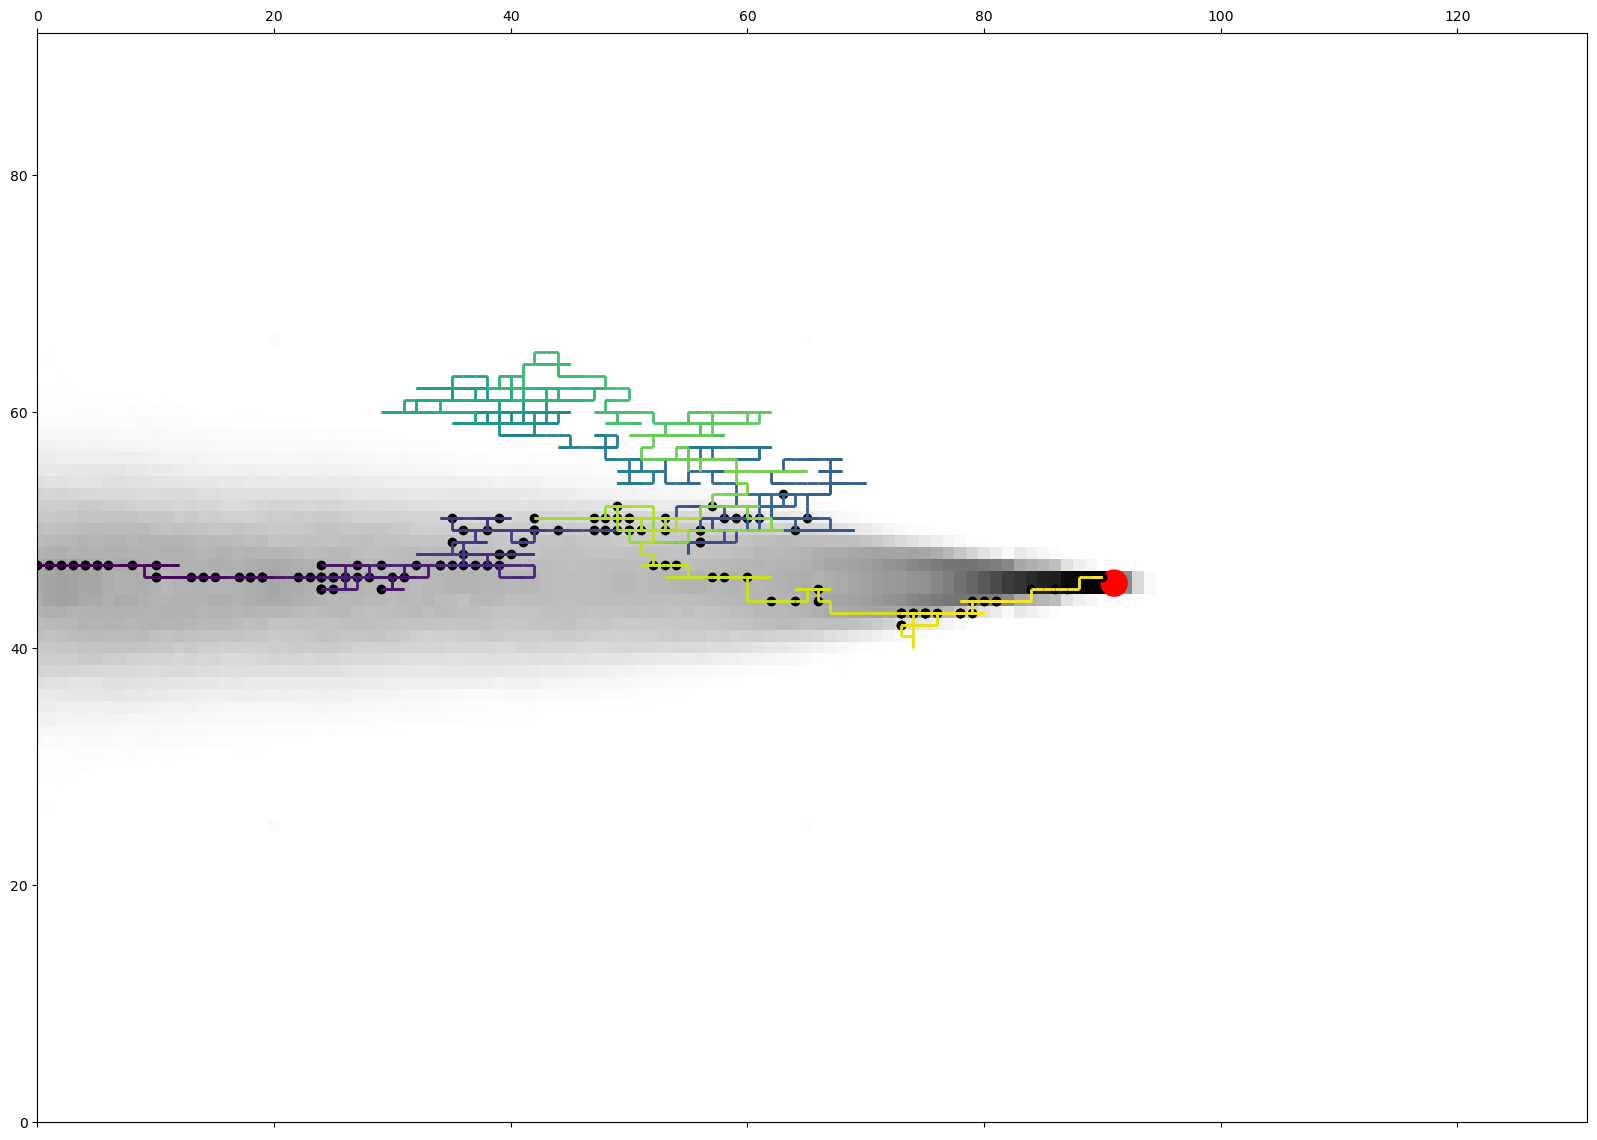

In [8]:
scemo = np.load("celaniData/fine5.npy").reshape((2, 131,92))
x, y = np.unravel_index(hst[0, :end], (131, 92))
cols = np.linspace(0,1, len(x))
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fig, ax = plt.subplots(figsize=(20,100))
lc = LineCollection(segments, cmap="viridis")
lc.set_linewidth(2)
lc.set_array(cols)
line = ax.add_collection(lc)
ax.set_xlim([0,131])
ax.set_ylim([0,92])

ax.matshow(scemo[1].T, cmap = "binary")
ax.add_patch(plt.Circle((91,45.5), 1.1, color="r"))
xObs = x[np.where(hst[1, :end])]
yObs = y[np.where(hst[1, :end])]
ax.scatter(xObs, yObs, c="k")
# plt.xticks([])
# plt.yticks([])

(0.0, 92.0)

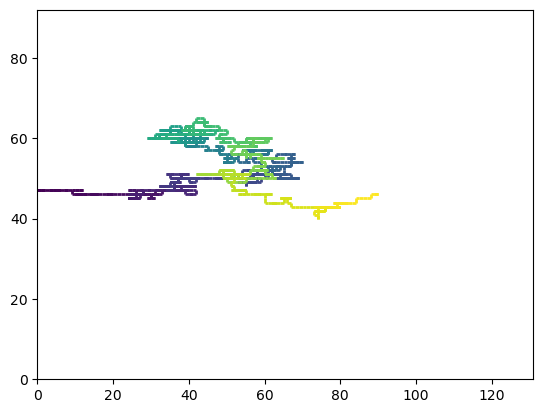

In [ ]:
x, y = np.unravel_index(hst[0, :end], (131, 92))
cols = np.linspace(0,1, len(x))
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fig, ax = plt.subplots()
lc = LineCollection(segments, cmap="viridis")
lc.set_linewidth(2)
lc.set_array(cols)
line = ax.add_collection(lc)
ax.set_xlim([0,131])
ax.set_ylim([0,92])

In [11]:
if M == 1:
    thOPt = np.load("results/modelBased/M1/celani/fine5/sparseCPUTest/theta_Conv8000.npy")
else:
    thOPt = np.loadtxt("celaniData/thetaLoroM2.txt").reshape((2,2,8))
Vopt, eta = mb.sparse_T_CPU(softmax(thOPt, axis=2), dataC, rSource, cSource, find_range, R, rho, M)
Vopt

array([-0.93625045, -0.93593798, -0.93531117, ..., -0.93524395,
       -0.93583609, -0.93613176])

In [12]:
globDir = f"results/TD_Lambda/M{M}/lambda_actor*/lambda_critic*/alphaActor_0.01_Scheduled_alphaCritic_0.15*/*provaM*/"
parents = sorted(glob.glob(globDir))

for parentDir in parents:
    print(parentDir)
    reg = re.compile(f"results/TD_Lambda/M{M}/lambda_actor([01]\\.[0-9]*)/lambda_critic([01]\\.[0-9]*)/alphaActor_([0-9]+\\.[0-9]*)(?:_Scheduled)?_alphaCritic_([0-9]+\\.[0-9]*)(?:_Scheduled)?/(.*)/")
    print(reg.match(parentDir).groups())

results/TD_Lambda/M1/lambda_actor0.8/lambda_critic0.8/alphaActor_0.01_Scheduled_alphaCritic_0.15_Scheduled/provaMemorie_episodes_350000/
('0.8', '0.8', '0.01', '0.15', 'provaMemorie_episodes_350000')


('1', '0.8', '0.8', '0.01', '0.15', 'provaMemorie_episodes_350000')
Actor Lambda 1; M 0.8; Lr 0.01
Critic Lambda 0.8; Lr 0.15; provaMemorie_episodes_350000


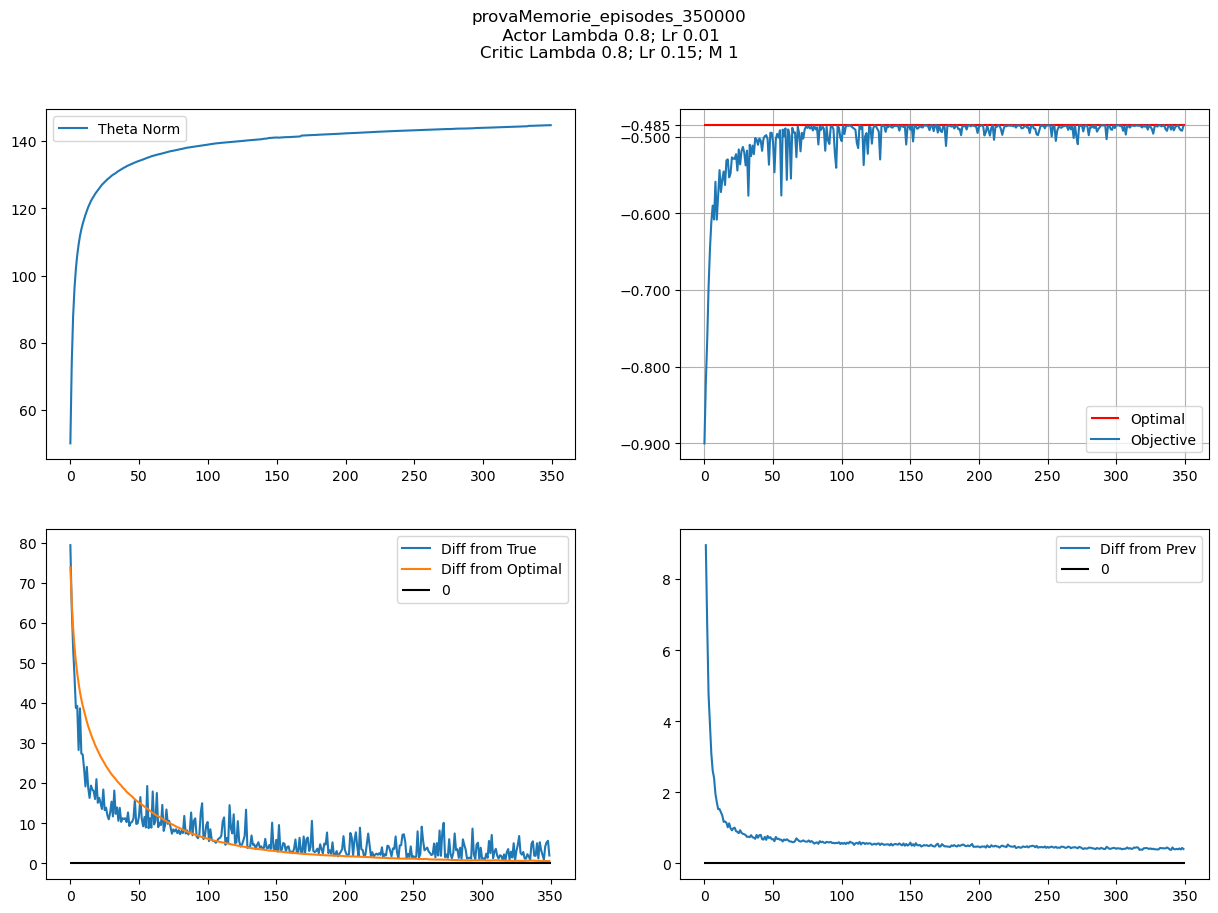

In [ ]:
parents = glob.glob(globDir)
for parentDir in parents:
    ls = glob.glob(parentDir+"Actors/theta*")
    totIter = len(ls) -2
    minTh = int(re.search("theta([0-9]+).npy", min(ls)).group(1))
    reg = re.compile("results/TD_Lambda/M([0-9])/lambda_actor([01]\\.[0-9]*)/lambda_critic([01]\\.[0-9]*)/alphaActor_([0-9]+\\.[0-9]*)(?:_Scheduled)?_alphaCritic_([0-9]+\\.[0-9]*)(?:_Scheduled)?/(.*)/")
    gr = reg.match(parentDir).groups()
    print(f"{gr}")
    print(f"Actor Lambda {gr[1]}; M {gr[0]}; Lr {gr[3]}\nCritic Lambda {gr[2]}; Lr {gr[4]}; {gr[5]}")
    normDiff = np.zeros(totIter)
    diffFromOpt = np.zeros(totIter)
    obj = np.zeros(totIter)
    thetas = np.zeros(totIter)
    diffPrev = np.zeros(totIter)
    for i in range(0, totIter):
        th = np.load(parentDir + f"Actors/theta{minTh + i*1000}.npy")
        thetas[i] = np.linalg.norm(th)
        trueV, _ = mb.sparse_T_CPU(softmax(th, axis = 2), dataC, rSource, cSource, find_range, R, rho, M)
        lambdaV = np.load(parentDir + f"Critics/critic{minTh + i*1000}.npy")
        obj[i] = np.dot(trueV, rho)
        normDiff[i] = np.linalg.norm(trueV - lambdaV, 2)
        diffFromOpt[i] = np.linalg.norm(lambdaV - Vopt, 2)
        if i > 0:
            diffPrev[i] = np.linalg.norm(lambdaV - prev)
        prev = lambdaV
    plot_and_save(totIter, thetas, obj, normDiff, diffFromOpt,diffPrev, gr[:5],gr[5] )    
    

In [ ]:
minTh

In [ ]:
i = 15100
0.1 / (i - 15000) if i > 15000 else 0.1

In [ ]:
plot_and_save(totIter, thetas, obj, normDiff, diffFromOpt, diffPrev, gr[:4], "scemo")

In [ ]:
delta = 0.001
value = -0.49
np.argmax(obj ) 

In [ ]:
obj[13], obj[0], obj[214], obj[54], obj[74], obj[226]

In [ ]:
plt.plot(range(100), range(100), "k--")
plt.vlines(50, 0, 100, "r", "--")

In [ ]:
def f(x):
    return 0.1 * 1000 / (1000 + x**(2/3))
def g(x):
    return 0.1 * 1000 / (1000 + x)
plt.plot(range(0, 50000, 1000), [f(a) for a in range(0,  50000, 1000)], label ="2/3")
plt.plot(range(0, 50000, 1000), [g(a) for a in range(0,  50000, 1000)], label ="1")
plt.hlines(0, *plt.xlim(), "k")
plt.legend()

In [ ]:
f(3), g(3)

In [ ]:
res = np.load("eval/results/objectiveOpt.npy")
res1 = np.load("eval/results/objective5.npy")
res2 = np.load("eval/results/objective6.npy")
res3 = np.load("eval/results/objective7.npy")
res4 = np.load("eval/results/objective9.npy")
np.histogram(res,[i for i in range(0, 10000-1, 200) ]+ [9999], (0,10000))

In [ ]:
np.count_nonzero(res == 10000)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(res,[i for i in range(0, 10000-1, 200) ]+ [9999], histtype="step", color="red", label="Optimal ~0.48")
ax.hist(res1,[i for i in range(0, 10000-1, 200) ]+ [9999], histtype="step", color="blue", label="~ 0.5")
ax.hist(res2,[i for i in range(0, 10000-1, 200) ]+ [9999], histtype="step", color="orange", label="~ 0.6")
ax.hist(res3,[i for i in range(0, 10000-1, 200) ]+ [9999], histtype="step", color="purple", label="~ 0.7")
ax.hist(res4,[i for i in range(0, 10000-1, 200) ]+ [9999], histtype="step", color="black", label="~ 0.9")
ax.add_patch(Rectangle((10800,0), 200, np.count_nonzero(res==10000), edgecolor="red", facecolor= "none"))
ax.add_patch(Rectangle((10600,0), 200, np.count_nonzero(res1==10000), edgecolor="blue", facecolor= "none"))
ax.add_patch(Rectangle((10200,0), 200, np.count_nonzero(res2==10000), edgecolor="orange", facecolor= "none"))
ax.add_patch(Rectangle((10400,0), 200, np.count_nonzero(res3==10000), edgecolor="purple", facecolor= "none"))
ax.add_patch(Rectangle((10000,0), 200, np.count_nonzero(res4==10000), edgecolor="black", facecolor= "none"))
# ax.set_ylim(0,5000)
plt.legend()

In [ ]:
avg = 0
for t in res4:
    tot = 0
    for i in range(int(t)):
        tot += -(1-0.99975) * 0.99975**i
    avg += tot
avg, avg / len(res4)

In [ ]:
for i in np.random.choice(res2, size=1000):
    print(i)

In [ ]:
avg = 0
samples = 2000
for t in np.random.choice(res1, samples):
    tot = 0
    if t == 10000:
        avg += -1
        continue
    for i in range(int(t)):
        tot += -(1-0.99975) * 0.99975**i
    avg += tot
avg, avg / samples

In [ ]:
avg = 0
for t in res1:
    tot = 0
    if t == 10000:
        avg += -1
        continue
    for i in range(int(t)):
        tot += -(1-0.99975) * 0.99975**i
    avg += tot
avg, avg / len(res1)

In [ ]:
tot = 0
for i in range(500000):
    tot += -(1-0.99975) * 0.99975**i
print(tot)

In [ ]:
cols

In [ ]:
np.argmax(rho)